# Reinforcement Learning based Trading Strategy




# Problem Definition

In this Reinforcement Learning framework for trading strategy, the algorithm takes an action (buy, sell or hold) depending upon the current state of the stock price. The algorithm is trained using Deep Q-Learning framework, to help us predict
the best action, based on the current stock prices. 

The key components of the RL based framework are :
* Agent: Trading agent.
* Action: Buy, sell or hold.
* Reward function: Realized profit and loss (PnL) is used as the reward function
for this case study. The reward depends upon the action:
    * Sell: Realized profit and loss (sell price - bought price)
    * Buy: No reward
    * Hold: No Reward 

* State: Differences of past stock prices for a given time window is used as the state.

<!-- The data used for this case study will be the standard and poor's 500. The link to the data is : https://ca.finance.yahoo.com/quote/%255EGSPC/history?p=%255EGSPC). -->

(Or, we use the data from the NASDAQ: https://ca.finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC&.tsrc=fin-srch or 
https://ca.finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC
but with NASDAQ you need to add param skip = 7000 to skip the first 7000 rows)

<a id='1.1'></a>
## Loading the python packages

In [1]:
!pip install keras

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Import Model Packages for reinforcement learning
from keras import layers, models, optimizers
from keras import backend as K
from collections import namedtuple, deque


## Loading the Data

In [2]:
#The data already obtained from yahoo finance is imported.
dataset = read_csv('data/SP500.csv',index_col=0)

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
type(dataset)

pandas.core.frame.DataFrame


# Exploratory Data Analysis

In [5]:
# shape
dataset.shape

(2516, 6)

In [6]:
# peek at data
set_option('display.width', 100)
dataset.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


The data has total 2,516 rows and six columns which contain the open, high, low,
close and adjusted close price along with the total volume. 

The adjusted close is the closing price adjusted for the split and dividends. 
For the purposes of reinforcement learning, we will focus on the live daily close prices, as the algo learns adaptively as you go, not based on delayed price adjustments.

In [7]:
# describe data
set_option('precision', 3)
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2516.000,2516.000,2516.000,2516.000,2516.000,2.516e+03
mean,1962.148,1971.347,1952.200,1962.609,1962.609,3.715e+09
std,589.031,590.191,587.624,588.910,588.910,8.134e+08
min,1027.650,1032.950,1010.910,1022.580,1022.580,1.025e+09
25%,1381.643,1390.700,1372.800,1384.405,1384.405,3.238e+09
50%,1985.320,1993.085,1975.660,1986.480,1986.480,3.588e+09
75%,2434.180,2441.523,2427.960,2433.968,2433.968,4.077e+09
max,3247.230,3247.930,3234.370,3240.020,3240.020,1.062e+10


Let us look at the plot of the stock movement. 

<AxesSubplot:xlabel='Date'>

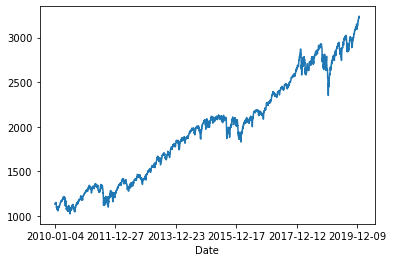

In [8]:
dataset['Close'].plot()


##  Data Preparation


## Data Cleaning
Let us check for the NAs in the rows, either drop them or fill them with the mean of the column

In [ ]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

In case there are null values fill the missing values with the last value available in the dataset. 

### As we have no missing values, comment out the cell below

In [ ]:
# # Fill the missing values with the last value available in the dataset. 
# dataset=dataset.fillna(method='ffill')
# dataset.head(2)

The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms


# Evaluate Algorithms and Models


##  Train Test Split

We will use 80% of the dataset for modeling
and use 20% for testing.

In [ ]:
X=list(dataset["Close"])
X=[float(x) for x in X]

In [ ]:
validation_size = 0.2
#In case the data is not dependent on the time series, then train and test split 
#should be done based on sequential sample
#This can be done by selecting an arbitrary split point in the ordered list of observations 
#and creating two new datasets.

train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]


##  Implementation steps

The algorithm, in simple terms decides whether to buy, sell or hold, when provided
with the current market price. The algorithm is based on “Q-learning based”
approach and used Deep-Q-Network (DQN) to come up with a policy. As discussed
before, the name “Q-learning” comes from the Q(s, a) function, that based on the
state s and provided action a returns the expected reward.


In order to implement this DQN algorithm several functions and modules are implemented that interact with each other during the model training. A summary of the
modules and functions is described below.

1. **Agent Class**: The agent is defined as “Agent” class, that holds the variables and
member functions that perform the Q-Learning that we discussed before. An
object of the “Agent” class is created using the training phase and is used for
training the model.
2. **Helper functions**: In this module, we create additional functions that are helpful
for training. There are two helper functions that we have are as follows.
3. **Training module**: In this step, we perform the training of the data using the vari‐
ables and the functions agent and helper methods. This will provide us with one
of three actions (i.e. buy, sell or hold) based on the states of the stock prices at the
end of the day. During training, the prescribed action for each day is predicted,
the rewards are computed and the deep-learning based Q-learning model
weights are updated iteratively over a number of episodes. Additionally, the profit
and loss of each action is summed up to see whether an overall profit has occur‐
red. The aim is to maximize the total profit.
We provide a deep dive into the interaction between different modules and functions
in the “Training the model” section below.
Let us look at the each of the modules in detail


##  Agent script

The definition of the Agent script is the key step, as it consists of the In this section, we will train an agent that will perform reinforcement learning based on the Q-Learning. We will perform the following steps to achieve this:

* Create an agent class whose initial function takes in the batch size, state size, and an evaluation Boolean function, to check whether the training is ongoing.
* In the agent class, create the following methods:
    * Constructor: The constructor inititalises all the parameters.
    * Model : This f unction has a deep learning model to map the state to action.
    * Act function :Returns an action, given a state, using the  output of the model function. The number of actions are defined as 3: sit, buy, sell
    * expReplay : Create a Replay function that adds, samples, and evaluates a buffer. Add a new experience to the replay buffer memory. Randomly sample a batch of experienced tuples from the memory. In the following function, we randomly sample states from a memory buffer. Experience replay stores a history of state, action, reward, and next state transitions that are experienced by the agent. It randomly samples mini-batches from this experience to update the network weights at each time step before the agent selects an ε-greedy action.

Experience replay increases sample efficiency, reduces the autocorrelation of samples that are collected during online learning, and limits the feedback due to the current weights producing training samples that can lead to local minima or divergence.

In [ ]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from IPython.core.debugger import set_trace

import numpy as np
import random
from collections import deque
# first we must create the Agent class
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        #State size depends and is equal to the the window size, n previous days
        self.state_size = state_size # normalized previous days, 
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        #self.epsilon_decay = 0.9
        
        #self.model = self._model()

        self.model = load_model(model_name) if is_eval else self._model()

    #Deep Q Learning model- returns the q-value when given state as input 
    def _model(self):
        model = Sequential()
        #Input Layer
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        #Hidden Layers
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        #Output Layer 
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
    
    #Return the action on the value function
    #With probability (1-$\epsilon$) choose the action which has the highest Q-value.
    #With probability ($\epsilon$) choose any action at random.
    #Intitially high epsilon-more random, later less
    #The trained agents were evaluated by different initial random condition
    #and an e-greedy policy with epsilon 0.05. This procedure is adopted to minimize the possibility of overfitting during evaluation.
 
    def act(self, state): 
        #If it is test and self.epsilon is still very high, once the epsilon become low, there are no random
        #actions suggested.
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)        
        options = self.model.predict(state)
        #set_trace()
        #action is based on the action that has the highest value from the q-value function.
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        
        # the memory during the training phase. 
        for state, action, reward, next_state, done in mini_batch:
            target = reward # reward or Q at time t    
            #update the Q table based on Q table equation
            #set_trace()
            if not done:
                #set_trace()
                #max of the array of the predicted. 
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])     
                
            # Q-value of the state currently from the table    
            target_f = self.model.predict(state)
            # Update the output Q table for the given action in the table     
            target_f[0][action] = target
            #train and fit the model where state is X and target_f is Y, where the target is updated. 
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


## Helper Functions

In this script, we will create functions that will be helpful for training. We create the following functions:

1) formatPrice:format the price to two decimal places, to reduce the ambiguity of the data:

2) getStockData: Return a vector of stock data from the CSV file. Convert the closing stock prices from the data to vectors, and return a vector of all stock prices.

3) getState: Define a function to generate states from the input vector. Create the time series by generating the states from the vectors created in the previous step. The function for this takes three parameters: the data; a time, t (the day that you want to predict); and a window (how many days to go back in time). The rate of change between these vectors will then be measured and based on the sigmoid function.

In [ ]:
import numpy as np
import math

# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# # returns the vector containing stock data from a fixed file 
# def getStockData(key):
#     vec = []
#     lines = open("data/" + key + ".csv", "r").read().splitlines()

#     for line in lines[1:]:
#         vec.append(float(line.split(",")[4])) #Only Close column

#     return vec

# returns the sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t

def getState(data, t, n):    
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()


## Training the data

We will proceed to train the data, based on our agent and helper methods. This will provide us with one of three actions, based on the states of the stock prices at the end of the day. These states can be to buy, sell, or hold. During training, the prescribed action for each day is predicted, and the price (profit, loss, or unchanged) of the action is calculated. The cumulative sum will be calculated at the end of the training period, and we will see whether there has been a profit or a loss. The aim is to maximize the total profit.

Steps: 
* Define the number of market days to consider as the window size and define the batch size with which the neural network will be trained.
* Instantiate the stock agent with the window size and batch size.
* Read the training data from the CSV file, using the helper function.
* The episode count is defined. The agent will look at the data for so many numbers of times. An episode represents a complete pass over the data.
* We can start to iterate through the episodes.
* Each episode has to be started with a state based on the data and window size. The inventory of stocks is initialized before going through the data.
* **Start to iterate over every day of the stock data. The action probability is predicted by the agent**. 
* Next, every day of trading is iterated, and the agent can act upon the data. Every day, the agent decides an action. Based on the action, the stock is held, sold, or bought.
* If the action is 1, then agent buys the stock. 
* If the action is 2, the agent sells the stocks and removes it from the inventory. Based on the sale, the profit (or loss) is calculated.

* If the action is 0, then there is no trade. The state can be called holding during that period.
* The details of the state, next state, action etc is saved in the memory of the agent object, which is used further by the exeReply function.       


In [ ]:
from IPython.core.debugger import set_trace
window_size = 1
agent = Agent(window_size)
#In this step we feed the closing value of the stock price 
data = X_train
l = len(data) - 1
#
batch_size = 32
#An episode represents a complete pass over the data.
episode_count = 10

for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)
    #set_trace()
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in range(l):
        action = agent.act(state)    
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            #print("Buy: " + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)      
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
            #print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

        done = True if t == l - 1 else False
        #appends the details of the state action etc in the memory, which is used further by the exeReply function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            #set_trace()
            #pd.DataFrame(np.array(agent.memory)).to_csv("Agent"+str(e)+".csv")
            #Chart to show how the model performs with the stock goin up and down for each 
            plot_behavior(data,states_buy, states_sell, total_profit)
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)    
            

    if e % 2 == 0:
        agent.model.save("model_ep" + str(e))

In [ ]:
#Deep Q-Learning Model
print(agent.model.summary())

<a id='6'></a>
# 6. Testing the Data 

After training the data, it is tested it against the test dataset. Our model resulted in a overall profit. The best thing about the model was that the profits kept improving over time, indicating that it was learning well and taking better actions.

In [ ]:
#agent is already defined in the training set above.
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
#Get the trained model
model_name = "model_ep"+str(episode_count)
agent = Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []

In [ ]:
for t in range(l_test):
    action = agent.act(state)
    #print(action)
    #set_trace()
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent.inventory.append(test_data[t])
        states_buy_test.append(t)
        print("Buy: " + formatPrice(test_data[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        #reward = test_data[t] - bought_price
        total_profit += test_data[t] - bought_price
        states_sell_test.append(t)
        print("Sell: " + formatPrice(test_data[t]) + " | profit: " + formatPrice(test_data[t] - bought_price))

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")
        
plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)

Looking at the results above, our model resulted in an overall profit of $1280, and we can say that our DQN agent performs quite well on the test set. However, the performance of the model can be further improved by optimizing the hyperparameters as discussed in the model tuning section before. Also, given high complexity and low interpretability of the model, ideally there should be more tests conducted on different time periods before deploying the model for live trading.

**Conclusion**

We observed that we don’t have to decide the strategy or policy
for trading. The algorithm decides the policy by itself, and the overall approach is
much simpler and more principled than the supervised learning-based approach. 

The
policy can be parameterized by a complex model, such as a deep neural network, and
we can learn policies that are more complex and powerful than any rules a human
trader.

We used the testing set to evaluate the model and found an overall profit in the test set.